[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


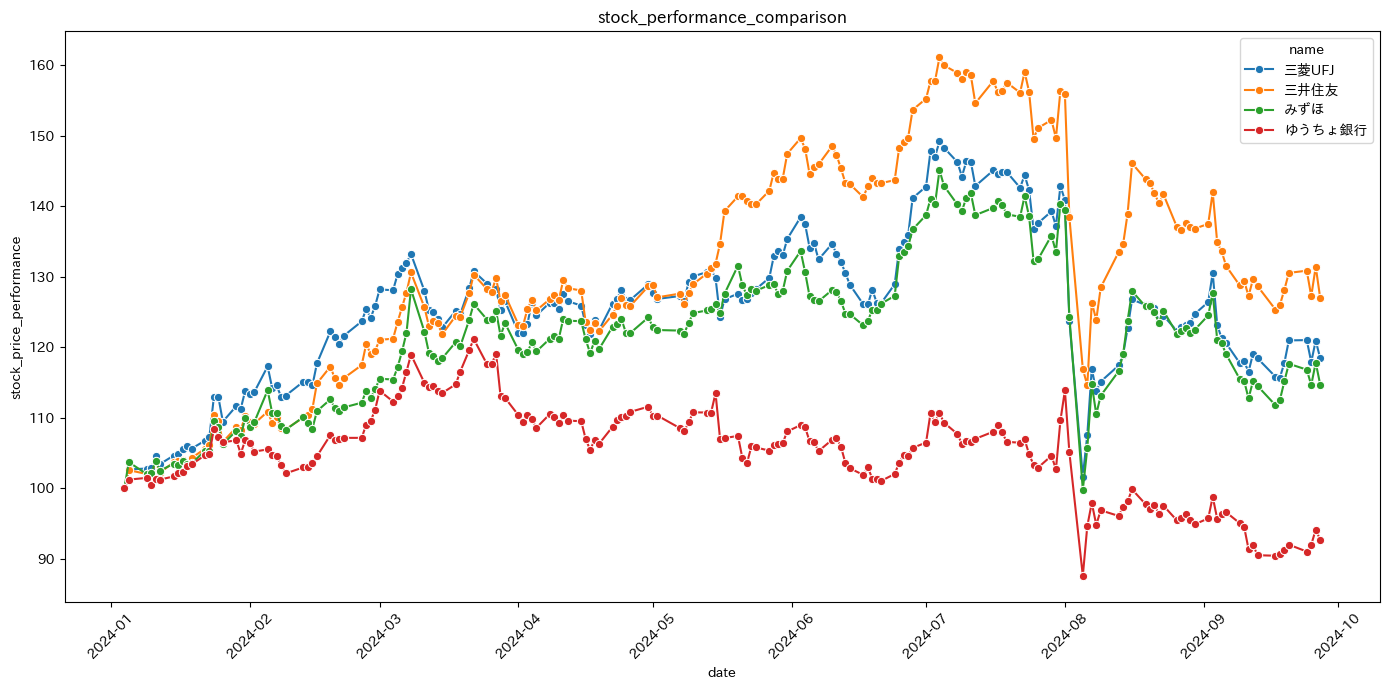

In [1]:
import os
import datetime as dt
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import japanize_matplotlib
import requests
from io import StringIO

# 銘柄コードのリスト
stock_codes = ['8306', '8316', '8411', '7182']
first = '2024-01-01'
last = dt.date.today()
dfs = []

stock_names_mapping_df = pd.read_csv('./stock_code_name_mapping.csv', usecols=[0,1])
stock_names_mapping_dict = dict(zip(stock_names_mapping_df['code'].astype(str), stock_names_mapping_df['name']))

# データの取得と正規化
for stock_code in stock_codes:
    ticker = stock_code + ".T"
    
    # データのダウンロード
    df = yf.download(ticker, start=first, end=last).reset_index().sort_values('Date')
    
    # 最初の日付のクローズ価格を取得（スカラー値）
    first_date = df['Date'].min()
    standard_value = df.loc[df['Date'] == first_date, 'Close'].iloc[0]
    
    # 正規化したクローズ価格を計算
    df[f'{stock_code}'] = (df['Close'] / standard_value) * 100
    
    # 必要な列だけを抽出
    dfs.append(df[['Date', f'{stock_code}']])

# データフレームのマージ
output_df = dfs[0]
for df in dfs[1:]:
    output_df = pd.merge(output_df, df, on='Date', how='inner')

# データを「長い形式」に変換
output_df_melted = output_df.melt(id_vars='Date', var_name='Stock_Code', value_name='Normalized_Close')

# 株コードを日本語の銘柄名に変換
output_df_melted['Stock_Name'] = output_df_melted['Stock_Code'].map(stock_names_mapping_dict)

# マッピングに失敗した場合の処理（未定義の銘柄コードを表示）
missing_names = output_df_melted[output_df_melted['Stock_Name'].isna()]['Stock_Code'].unique()
if len(missing_names) > 0:
    print(f"以下の株コードの銘柄名がマッピングされていません: {missing_names}")
    # 必要に応じて手動で追加
    for code in missing_names:
        stock_names_mapping_dict[code] = code  # 例として株コードをそのまま使用
    output_df_melted['Stock_Name'] = output_df_melted['Stock_Code'].map(stock_names_mapping_dict)

# プロットの作成
plt.figure(figsize=(14, 7))
sns.lineplot(data=output_df_melted, x='Date', y='Normalized_Close', hue='Stock_Name', marker='o')
plt.title('stock_performance_comparison')
plt.xlabel('date')
plt.ylabel('stock_price_performance')
plt.legend(title='name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
